# Minipatch for Shapley values

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.special import binom 
from itertools import combinations

In [56]:
import shap
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [57]:
import seaborn as sns
# from tqdm.notebook import trange

In [58]:
import sys
sys.path.append('./shapley_compute/')
from shapley_compute.ensembled_mp import mp_shapley
from shapley_compute.minipatches import minipatch_regression_loo, get_minipatch

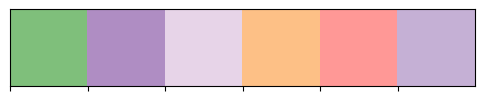

In [59]:
palette = sns.color_palette([
    "#7fbf7b",  # Light Green
    "#af8dc3",  # Lavender
    "#e7d4e8",  # Light Purple
    "#fdc086",  # Light Orange
    "#ff9896",  # Light Red
    "#c5b0d5"   # Light Blue
])

# Display the palettes
sns.palplot(palette)

Reworked by only considering the subset sampled in minipatches. Let $d_K = \sum_k F_k$ total of combinations of features sampled in minipatch.
$$\hat{\phi}_{j}^{\text{MP-LOO}}(X_i) = \frac{1}{d} \sum_{k: j \notin F_k} {{d-1}\choose{|F_k|}}^{-1} \bigg( \frac{1}{\sum_{l: F_l=F_k\cup\{j\} } \mathbb{I}(i \notin I_l) \mathbb{I}(j \notin F_k)} \sum_{l: F_l=F_k\cup\{j\} } \mathbb{I}(i \notin I_l) \hat{f}_{(I_l,F_l)}^{-i}(X_{i, F_l}) - \frac{1}{\sum_{k:j \notin F_k} \mathbb{I}(i \notin I_k) \mathbb{I}(j \notin F_k)} \mathbb{I}(i \notin I_k) \hat{f}_{(I_k, F_k)}^{-i} (X_{i, F_k})\bigg)$$

Approximation:
- $(\hat{f}^{-i}_{(I_k, F_k)})_{k = 1}^K$
- $(F_k)_{k=1}^K \propto \mathcal{P}(\{1, \dots, d \})$ 

## Data/benchmarking
- Toy examples with a few correlated features : benchmark datasets 


In [75]:
# California Housing Prices
dataset = fetch_california_housing(as_frame = True)
X = dataset['data']
y = dataset['target']
model = LinearRegression()

### Tests with exact shapley

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Prepares a default instance of the random forest regressor
model = RandomForestRegressor()

# Fits the model on the data
model.fit(X_train, y_train)

# Fits the explainer
explainer = shap.Explainer(model.predict, X_train)
# Calculates the SHAP values - It takes some time
#shap_values_lr = explainer(X_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Prepares a default instance of the random forest regressor
model = RandomForestRegressor()
sample_size = 100  # Adjust the sample size according to your computational resources
sampled_indices = np.random.choice(X_train.shape[0], size=sample_size, replace=False)
X_sample = np.array(X_train)[sampled_indices]
y_sample = np.array(y_train)[sampled_indices]

# Fits the model on the data
model.fit(X_sample, y_sample)

# Fits the explainer
explainer = shap.KernelExplainer(model.predict, X_sample)
# Calculates the SHAP values - It takes some time
kernelSHAP = explainer(X_test)

 19%|█▉        | 785/4128 [01:47<07:33,  7.38it/s]

In [114]:
shap_values_lr = explainer(X_test)

Exact explainer: 4129it [11:21,  5.97it/s]                          


<Axes: >

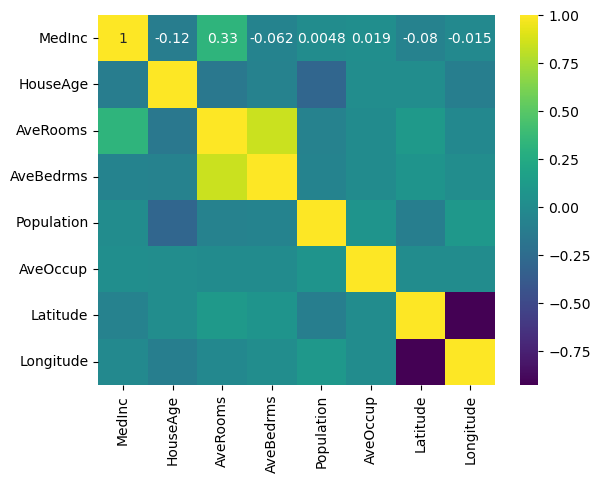

In [63]:
sns.heatmap(X.corr(), annot=True,cmap='viridis')

In [90]:
y_train

17302    2.510
16963    3.882
7386     1.051
6787     1.928
11310    1.885
         ...  
12779    0.498
9422     3.500
17353    1.580
14439    2.763
17191    2.861
Name: MedHouseVal, Length: 16512, dtype: float64

In [83]:
model = RandomForestRegressor()

In [91]:
from shapley_compute.minipatches import minipatch_regression
from shapley_compute.ensembled_mp import shapley_mp, mp_shapley
x_ratio = 0.02
B = 1000
res = minipatch_regression(np.array(X_train), np.array(y_train), np.array(X_test), model, x_ratio, B)


In [100]:
res[0].shape, res[1].shape, res[2].shape, X_test.shape

((1000, 4128, 1), (1000, 16512), (1000, 8), (4128, 8))

In [110]:
# approx_shap = mp_shapley(X_test, res)
import tqdm
new_shap = np.zeros((X_test.shape))
for i in tqdm.tqdm(range(X_test.shape[1])): 
    new_shap[:,i] = shapley_mp(i, res)

100%|██████████| 8/8 [00:00<00:00, 41.87it/s]


In [115]:
new_shap.shape, shap_values_lr.shape

((4128, 8), (4128, 8))

In [64]:
# np.save('./shapley_file/exact_SHAP_linear.npy', shap_values_lr)

In [65]:
shap_values = np.load('./shapley_files/exact_SHAP.npy', allow_pickle=True)

In [66]:
shap_values = shap_values.ravel()[0]
# shap_values_lr.values

In [67]:
shap_values['base_values'].shape

(4128,)

In [137]:
np.mean(np.abs(new_shap),axis=0)

array([4.75129517e-05, 1.59962383e-05, 3.68254022e-05, 1.55782296e-05,
       1.39529951e-05, 3.34124538e-05, 4.44432757e-05, 5.11452570e-05])

In [138]:
np.sum(np.abs(shap_values['values']),axis=0)

array([2054.94032739,  326.79036497,  234.35190874,  128.07172767,
         88.62288633,  887.59615228, 1568.73271796, 1222.03993324])

In [70]:
# shap.plots.bar(shap_values)

In [71]:
# shap.plots.beeswarm(shap_values)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title('Exact Shapley')
# Width of each bar
bar_width = 0.2

# Calculate the positions for the bars
pos1 = np.arange(len(feature_names))

ax.barh(pos1-w, np.mean(np.abs(shap_values_lr.values),axis=0), width=1, alpha=0.2)
ax.barh(pos1, np.sum(np.abs(new_shap),axis=0), width=1,alpha=0.5)
ax.barh(pos1+w, np.mean(np.abs(kernelSHAP),axis=0),width=1, alpha=0.5)
ax.set_ylabel(feature_names)
ax.set_title('Minipatch Shapley B = {}'.format(B))
ax.legend(['Exact shapley','MP shapley', 'KernelSHAP'])



plt.suptitle('Shapley values on training California housing dataset')
plt.savefig('./figures/cal_data_shap_reg_1.svg')

In [ ]:
# np.save('./exact_SHAP.npy', d)

### Minipatch ensemble Shapley

In [73]:
X_arr = np.array(X_train)

NameError: name 'X_train' is not defined

In [74]:
y_arr = np.array(y_train)

NameError: name 'y_train' is not defined

In [35]:
def get_minipatch(X_arr,y_arr, x_ratio=0.02):
    N = len(X_arr)
    M = len(X_arr[0])
    assert int(np.round(x_ratio * N)) > M # verify that enough observations are sampled
    
    # get a random feature size
    m =  np.random.choice([i for i in range(1,M)])
    n = int(np.round(x_ratio * N))
    
    r = np.random.RandomState()
    ## index of minipatch
    idx_I = np.sort(r.choice(N, size=n, replace=False)) # uniform sampling of subset of observations
    idx_F = np.sort(r.choice(M, size=m, replace=False)) # uniform sampling of subset of features
    ## record which obs/features are subsampled 
    x_mp = X_arr[np.ix_(idx_I, idx_F)]
    y_mp = y_arr[np.ix_(idx_I)]
    return x_mp, y_mp, idx_I, idx_F


In [169]:
get_minipatch(X_arr,y_arr)[0].shape

(330, 2)

In [107]:
def minipatch_regression(X_arr, y_arr, Xi, model, x_ratio, B=1000, plot_prop=False):
    pred = []
    mp_feat_size = []
    N = X_arr.shape[0]
    M = X_arr.shape[1]
    in_mp_obs, in_mp_feature = np.zeros((B,N),dtype=bool),np.zeros((B,M),dtype=bool)
    for b in range(B):  
        x_mp, y_mp, idx_I, idx_F = get_minipatch(X_arr, y_arr, x_ratio)
        mp_feat_size.append(len(idx_F))
        model.fit(x_mp, y_mp)
        pred.append(pd.DataFrame(model.predict(np.array(Xi)[:, idx_F])))
        in_mp_obs[b,idx_I] = True # minipatch b 
        in_mp_feature[b,idx_F] = True
    if plot_prop:
        plt.hist(mp_feat_size)
        plt.suptitle('Minipatch length histogram')
    
    return [np.array(pred),in_mp_obs,in_mp_feature]

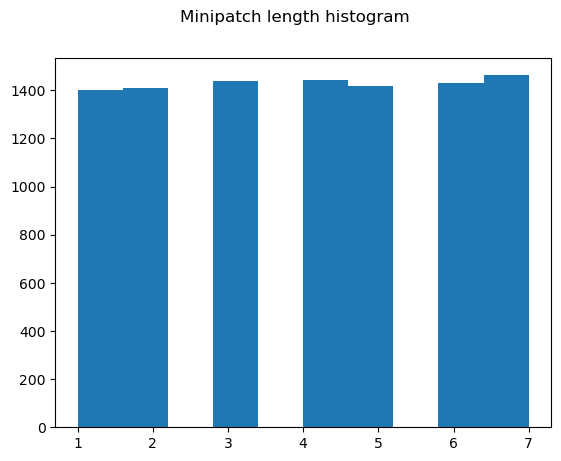

In [170]:
res = minipatch_regression(X_arr, y_arr, X_test, model, 0.02, B=10000, plot_prop=True)

In [109]:
def visualise_minipatch(in_mp_obs, in_mp_feature, color_palette = palette, type='sorted'):
    
    B = in_mp_obs.shape[0]
    matrix = np.zeros((in_mp_obs.shape[1],in_mp_feature.shape[1]))
    for i in range(B):
        matrix += (in_mp_obs[i][:, np.newaxis] & in_mp_feature[i]).astype(int)
    df = pd.DataFrame(matrix, columns = X.columns)
    if type =='sorted':
        sns.heatmap(df[df.mean().sort_values().index].sort_values(by=df[df.mean().sort_values().index].columns[-1], axis=0), cmap=palette)
    else:
        sns.heatmap(df, cmap=palette)
    plt.title('Patch selection frequency')
    

In [110]:
pred, in_mp_obs, in_mp_feature = res

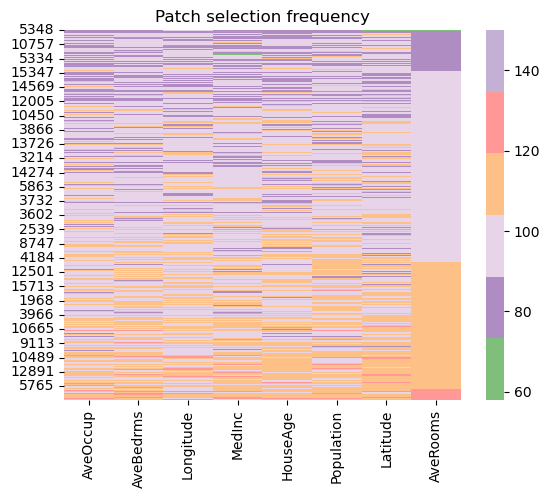

In [111]:
visualise_minipatch(in_mp_obs, in_mp_feature, type='sorted')

In [130]:
pred.shape

(10000, 4128, 1)

In [159]:

target_feature = 2
def naive_shapley_mp(target_feature, res):
    pred, in_mp_obs, in_mp_feature = res
    d = len(in_mp_feature[0])
    m = np.sum(in_mp_feature,axis=1)[0]
    n = np.sum(in_mp_obs, axis=1)[0]
    all_features = [list(combinations(set([i for i in range(d)]),j)) for j in range(1,d)] # list of all subsets possible of features
    # all_features[i] contains list of all i-uplet of combinations of features
    features_target = [[combo for combo in all_features[i] if target_feature not in combo] for i in range(len(all_features))] # exclude target feature
    diff = []
    for i in range(len(features_target)):
        for j in range(len(features_target[i])):
        
            val_diff = np.zeros(pred.shape[1])
            feature_subset = features_target[i][j]
            target_indices = np.where(in_mp_feature[:,target_feature])[0] # Get the indices of the rows where the target column is True
            
            oh = np.zeros(d, dtype=bool)
            oh[[feature_subset]] = True # one hot feature subset
            oh_j = np.zeros(d, dtype=bool)
            l = list(feature_subset)
            l.append(target_feature)
            oh_j[[l]] = True # one hot feature subset + target
            
            mask = np.all(in_mp_feature == oh, axis=1) # mask the feature subset 
            right_indices = np.where(mask)[0] # find matching indices of mask 
            mask_j = np.all(in_mp_feature == oh_j, axis=1) # mask the feature subset + target
            left_indices = np.where(mask_j)[0] 
            
            if (len(left_indices) ==0) or (len(right_indices)==0) :
                pass
            else:
                augmented_pred = pred[list(left_indices),:,0]
                # augmented_idx = in_mp_obs[list(left_indices),:]
                selected_pred = pred[list(right_indices),:,0]
                # selected_idx = in_mp_obs[list(right_indices),:]
                phi_right = np.mean(selected_pred) # np.mean(np.array([selected_pred[i,:][selected_idx[i,:]] for i in range(selected_idx.shape[0])]),axis=0)
                phi_left = np.mean(augmented_pred) # np.mean(np.array([augmented_pred[i,:][augmented_idx[i,:]] for i in range(augmented_idx.shape[0])]),axis=0)
                                         
                val_diff += phi_left - phi_right
        diff.append(1/binom(d-1,len(feature_subset)) * val_diff)
    shapley_j = 1/d*sum(diff)

    return shapley_j 


In [140]:
def mp_shapley(Xi, res):
    new_shap = np.zeros((Xi.shape))
    for i in range(Xi.shape[1]): 
        new_shap[:,i] = shapley_mp(i, res)
    return new_shap

Using minipatch to ensemble shapley for subset $u \subset \{1, \dots, d\}$.
$$\hat{\phi}_{j} = \frac{1}{d} \sum_{u \subset [d]\setminus\{j\}} {{d-1}\choose{|u|}}^{-1} \bigg( \frac{1}{K} \sum_{k:(I_k,F_k): F_k=u\cup\{j\} } \hat{f}_{X_{I_k,F_k},Y_{I_k}}(X_{F_k}) - \sum_{k:(I_k,F_k'): F_{k}^{'} = u} \frac{1}{\sum_k I(j \notin F_{k}^{'})} \hat{f}(X_{F_k}^{'})\bigg)$$

In [53]:
pred, in_mp_obs, in_mp_feature = res
all_features = np.unique(in_mp_feature,axis=0) # get all features sampled in MPs
print(all_features.shape[0])

ValueError: too many values to unpack (expected 3)

In [54]:
# for each minipatch, set last observation to test set 
x_mp, y_mp, idx_I, idx_F = get_minipatch(X_arr, y_arr, 0.4)
x_mp[:-1,:].shape, y_mp.shape, x_mp[-1,:]

NameError: name 'X_arr' is not defined

In [266]:
def minipatch_regression_loo(X_arr, y_arr, model, x_ratio, B=1000, plot_prop=False):
    """ Fit the minipatch ensemble estimator on the training data and predict on leave-one-out Xi
    Input:
        X_arr: training predictors
        y_arr: training set response
        Xi: test set
        model: chosen model for regression
        x_ratio: ratio of observation to sample from
        B: number of replicates
        plot_prop: if True, plots the minipatch feature coverage histogram
    -------
    Outputs: 
        [np.array, np.array, np.array]: prediction on test set, boolean dictionary of minipatch observations, boolean dictionary of minipatch features
    """
    pred = []
    mp_feat_size = []
    N = X_arr.shape[0]
    M = X_arr.shape[1]
    in_mp_obs, in_mp_loo, in_mp_feature = np.zeros((B,N),dtype=bool), np.zeros((B,N),dtype=bool), np.zeros((B,M),dtype=bool)
    for b in range(B):  
        x_mp, y_mp, idx_I, idx_F = get_minipatch(X_arr, y_arr, x_ratio)
        mp_feat_size.append(len(idx_F))
        model.fit(x_mp[:-1,:], y_mp[:-1]) # leave-one-out
        Xi = x_mp[-1,:]
        pred.append(pd.DataFrame(model.predict(Xi.reshape(1,-1))))
        in_mp_obs[b,idx_I[:-1]] = True # minipatch b train points
        in_mp_feature[b,idx_F] = True
        in_mp_loo[b, idx_I[-1]] = True # test point loo
    if plot_prop:
        plt.hist(mp_feat_size)
        plt.suptitle('Minipatch length histogram')
    
    return [np.array(pred),in_mp_obs,in_mp_loo, in_mp_feature]

In [267]:
res = minipatch_regression_loo(X_arr, y_arr, model, x_ratio=0.2, B=1000, plot_prop=False)

In [300]:
X_test = X_arr[np.where(in_mp_loo == True)[1],:] # from minipatch

### rebuild

In [327]:

def shapley_mp(target_feature, res):
    pred, in_mp_obs, in_mp_loo, in_mp_feature = res
    pred = np.array(pred)
    n = np.sum(in_mp_obs, axis=1)[0]
    all_features = np.unique(in_mp_feature,axis=0) # get all features sampled in MPs
    # all_features is now one-hot encoding of the positions 
    features_target = all_features[np.where(all_features[:,target_feature]==False)] # ohe for the feature subsets that exclude target feature
    dk = features_target.shape[0]
    d = all_features.shape[0]
    
    diff = []
    for row in features_target[:2]:
        val_diff = 0 
        row_j = row.copy()
        row_j[target_feature] = True
    
        # get in in_mp_feature the corresponding elements 
        mask = np.all(in_mp_feature == row, axis=1)
        mask_j =  np.all(in_mp_feature == row_j, axis=1)
        if in_mp_feature[mask_j].shape[0] == 0:
            pass
        else:
            mu_k = np.mean(pred[mask,:,0],axis=0)
            mu_j = np.mean(pred[mask_j,:,0], axis=0)
        val_diff = mu_j - mu_k
        diff.append(dk/binom(dk-1,sum(row)) * val_diff)
    shapley_j = sum(diff)
    return shapley_j

In [282]:
print('mu_k: ', pred[mask,:,0].shape, 'Ik: ', in_mp_obs[mask].shape, 'Fk: ', in_mp_feature[mask].shape)

mu_k:  (22, 1) Ik:  (22, 16512) Fk:  (22, 8)


In [281]:
print('mu_k: ', pred[mask_j,:,0].shape, 'Ik: ', in_mp_obs[mask_j].shape, 'Fk: ', in_mp_feature[mask_j].shape)

mu_k:  (4, 1) Ik:  (4, 16512) Fk:  (4, 8)


### build

In [122]:
X_test.shape[0]

4128

In [125]:
Xi = X_test
target_feature = 2
pred, in_mp_obs, in_mp_feature = res
d = len(in_mp_feature[0])
pred = np.array(pred)
n = np.sum(in_mp_obs, axis=1)[0]
all_features = [list(combinations(set([i for i in range(d)]),j)) for j in range(1,d)] # list of all subsets possible of features
# all_features[i] contains list of all i-uplet of combinations of features
features_target = [[combo for combo in all_features[i] if target_feature not in combo] for i in range(len(all_features))] 
        # list of positions for the feature subsets that exclude target feature
diff = []

for i in range(len(features_target)):
    for j in range(len(features_target[i])):
        
        val_diff = np.zeros(Xi.shape[0])
        feature_subset = features_target[i][j]
        target_indices = np.where(in_mp_feature[:,target_feature])[0] # Get the indices of the rows where the target column is True
        
        oh = np.zeros(d, dtype=bool)
        oh[[feature_subset]] = True # one hot feature subset
        oh_j = np.zeros(d, dtype=bool)
        l = list(feature_subset)
        l.append(target_feature)
        oh_j[[l]] = True # one hot feature subset + target
        
        mask = np.all(in_mp_feature == oh, axis=1) # mask the feature subset 
        right_indices = np.where(mask)[0] # find matching indices of mask 
        mask_j = np.all(in_mp_feature == oh_j, axis=1) # mask the feature subset + target
        left_indices = np.where(mask_j)[0] 
        if (len(left_indices) ==0) or (len(right_indices)==0) :
            pass
        else:
            augmented_pred = pred[list(left_indices),:,0]
          
            # augmented_idx = in_mp_obs[list(left_indices),:]
            selected_pred = pred[list(right_indices),:,0]

            # selected_idx = in_mp_obs[list(right_indices),:]
            phi_right = np.mean(selected_pred, axis=0) # np.mean(np.array([selected_pred[i,:][selected_idx[i,:]] for i in range(selected_idx.shape[0])]),axis=0)
            phi_left = np.mean(augmented_pred, axis=0) #  np.mean(np.array([augmented_pred[i,:][augmented_idx[i,:]] for i in range(augmented_idx.shape[0])]),axis=0)
                                         
            val_diff += phi_left - phi_right
    diff.append(1/binom(d-1,len(feature_subset)) * val_diff)
shapley_j = 1/d*sum(diff)


In [126]:
shapley_j

array([ 0.03627962,  0.01069462,  0.02287626, ..., -0.02753866,
        0.02550613,  0.03425982])

In [90]:
np.mean(np.array([selected_pred[i,:][selected_idx[i,:]] for i in range(selected_idx.shape[0])]),axis=0).shape

(330,)

In [67]:
i = 0
j = 1
val_diff = 0 
feature_subset = features_target[i][j]
target_indices = np.where(in_mp_feature[:,target_feature])[0] # Get the indices of the rows where the target column is True
# print(d)
oh = np.zeros(d, dtype=bool)
oh[[feature_subset]] = True # one hot feature subset
oh_j = np.zeros(d, dtype=bool)
l = list(feature_subset)
l.append(target_feature)
oh_j[[l]] = True # one hot feature subset + target

mask = np.all(in_mp_feature == oh, axis=1) # mask the feature subset 
right_indices = np.where(mask)[0] # find matching indices of mask 
mask_j = np.all(in_mp_feature == oh_j, axis=1) # mask the feature subset + target
left_indices = np.where(mask_j)[0] 

augmented_pred = pred[list(left_indices),:,0]
augmented_idx = in_mp_obs[list(left_indices),:]
selected_pred = pred[list(right_indices),:,0]
selected_idx = in_mp_obs[list(right_indices),:]
phi_right = np.mean(np.array([selected_pred[i,:][selected_idx[i,:]] for i in range(selected_idx.shape[0])]),axis=0)
phi_left = np.mean(np.array([augmented_pred[i,:][augmented_idx[i,:]] for i in range(augmented_idx.shape[0])]),axis=0)
                             
val_diff += phi_left - phi_right


In [69]:
phi_left.shape

(330,)

In [ ]:
def mp_value_holdout(feature_subset, pred, in_mp_obs, in_mp_feature, holdout_feature):
    pred = np.array(pred)
    feat_wo_target = in_mp_feature[~in_mp_feature[:, holdout_feature]]
    selected = np.where(np.any(feat_wo_target[:, feature_subset], axis=1)) # gives the k that correspnod
    # print('holdout',np.mean(pred[selected,:], axis = 1)[0].shape)
    return np.mean(pred[selected,:], axis = 1)[0]
    
        

In [47]:
def mp_value(feature_subset, pred, in_mp_obs, in_mp_feature, holdout_feature):
    ext_subset = list(feature_subset)
    ext_subset.append(holdout_feature)
    pred, in_mp_obs, in_mp_feature = res 
    pred = np.array(pred)
    selected = np.where(np.any(in_mp_feature[:, ext_subset], axis=1))
    # print('full',np.mean(pred[selected,:], axis = 1)[0].shape)
    return np.mean(pred[selected,:], axis = 1)[0]
    
    

### Continue

In [331]:
new_shap = np.zeros((X_test.shape))
for i in range((X_test).shape[1]): 
    new_shap[:,i] = shapley_mp(i, res)

Text(0.5, 1.0, 'Exact Shapley')

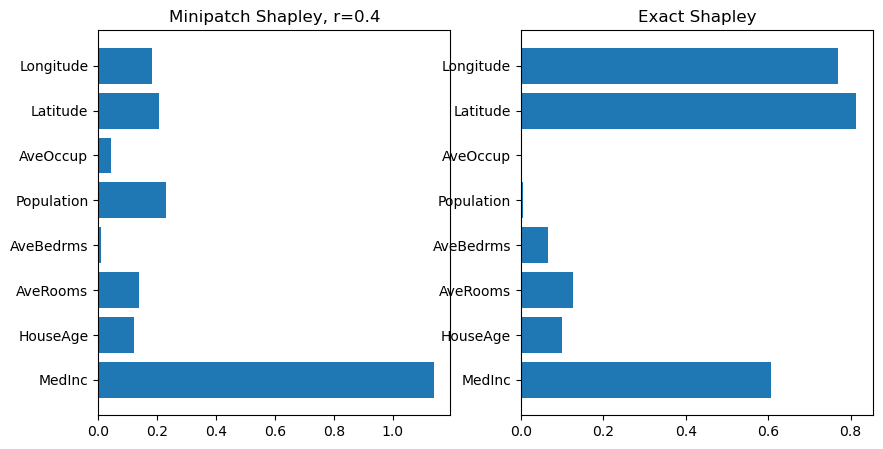

In [336]:
x_ratio=0.4
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].barh(X.columns, np.mean(np.abs(new_shap),axis=0))
ax[0].set_title('Minipatch Shapley, r={}'.format(x_ratio))
ax[1].barh(X.columns, np.mean(np.abs(shap_values_lr.values),axis=0))
ax[1].set_title('Exact Shapley')

In [142]:
res = minipatch_regression(X_arr, y_arr, X_test, model, 0.2, 100)
shap100 = mp_shapley(X_test, res)

NameError: name 'new_shap_lr' is not defined

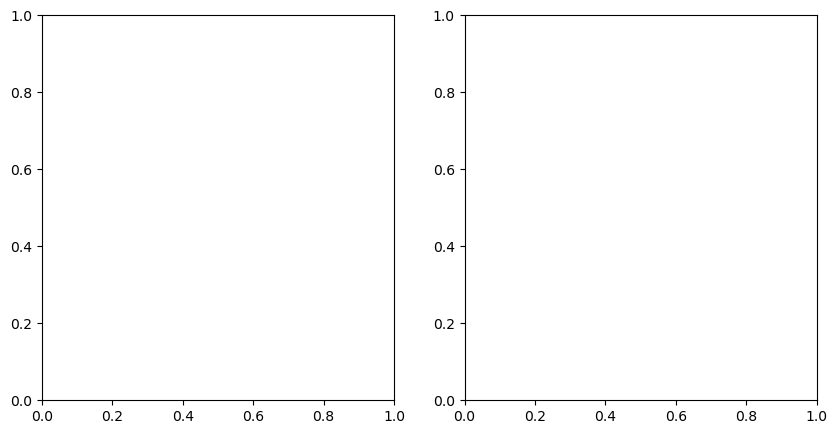

In [340]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].barh(X.columns, np.mean(np.abs(new_shap_lr),axis=0))
ax[0].set_title('Minipatch Shapley, r=0.2')
ax[1].barh(X.columns, np.mean(np.abs(shap_values_lr.values),axis=0))
ax[1].set_title('Exact Shapley')

### Experiments 
Run with different ratios for sampling ? different number of patches?

In [7]:
help(get_minipatch)

Help on function get_minipatch in module shapley_compute.minipatches:

get_minipatch(X_arr, y_arr, x_ratio=0.02, seed=None)
    Generate a minipatch from a dataset with covariates X, with obs size controled by ratio parameters
    Input: 
        X_arr
        y_arr
        x_ratio
    -------
    Outputs: 
        x_mp
        y_mp
        idx_I
        idx_F



In [37]:
feature_names = X.columns
X = np.array(X)
y = np.array(y)

In [21]:
res[

(20640, 8)

In [22]:
X[np.where(res[2] == False)[1],:].shape

(41278000, 8)

In [52]:
res =  minipatch_regression_loo(X, y, model, 0.2, 2000, r=1)
model.fit(X[np.unique(np.where(res[2] == False)[1]),:] ,np.array(y)[np.unique(np.where(res[2] == False)[1])] )
X_test = X[np.unique(np.where(res[2] == True)[1]),:] 
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/clairehe/anaconda3/envs/mpshapley/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 173, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(array([[    4],
       [    6],
       [    7],
       ...,
       [20621],
       [20624],
       [20629]]), array([[0, 2, 3, 4, 6]]))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/clairehe/anaconda3/envs/mpshapley/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/r4/_v5hj9j14b53twvkrltmh9vh0000gn/T/ipykernel_21302/336516647.py", line 1, in <module>
    res =  minipatch_regression_

In [ ]:
shap_exact = explainer(X_test)

In [50]:
ratio = [0.1, 0.2, 0.5]
shap1 = []
shap2 = []
shap3 = []
for i in range(len(ratio)):
    res = minipatch_regression_loo(X, y, model, ratio[i], 2000, 111+i)
    shap1.append(mp_shapley(X_test, res))
    res2 = minipatch_regression_loo(X, y, model, ratio[i], 5000, 123+i)
    shap2.append(mp_shapley(X_test, res2))
    res3 = minipatch_regression_loo(X, y, model, ratio[i], 10000, 222+i)
    shap3.append(mp_shapley(X_test, res3))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/clairehe/anaconda3/envs/mpshapley/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 173, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(array([[    2],
       [    5],
       [   19],
       ...,
       [20609],
       [20622],
       [20629]]), array([[1, 2, 3, 4, 5, 6, 7]]))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/clairehe/anaconda3/envs/mpshapley/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/r4/_v5hj9j14b53twvkrltmh9vh0000gn/T/ipykernel_21302/2751101826.py", line 6, in <module>
    res = minipatch_regre

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(20,10))
ax[0].set_title('Exact Shapley')
ax[0].barh(feature_names, np.mean(np.abs(shap_exact.values),axis=0), alpha=0.8)

for i in range(1,4):
    
    ax[i].barh(feature_names, np.mean(np.abs(shap1[i-1]),axis=0), alpha=0.5)
    ax[i].barh(feature_names, np.mean(np.abs(shap2[i-1]),axis=0), alpha=0.5)
    ax[i].barh(feature_names, np.mean(np.abs(shap3[i-1]),axis=0), alpha=0.5)
    ax[i].set_title('Minipatch Shapley r = {}'.format(ratio[i-1]))
    ax[i].legend(['B=2000','B=5000', 'B=10000'])



plt.suptitle('Shapley values on training California housing dataset')
plt.savefig('./figures/cal_data_shap_reg_1.svg')

In [51]:
shap1

[]

# For future revision of code

In [ ]:
# Create minipatch
class MiniPatch_Constructor():
    
    @abstractmethod
    def __init__(num_mp, num_feat, num_obs):
        # Set parameters
        self.num_mp = num_mp # number of minipatches
        self.num_feat = num_feat # number of features per patch
        self.num_obs = num_obs # number of observations per patch
        
    def _get_minipatch(
        # get a minipatch of size (n, m)
        N = len(X_arr)
        M = len(X_arr[0])
        n = int(np.round(0.2 * N))
        m = int(np.round(0.2 * M))
        r = np.random.RandomState()
        ## index of minipatch
        idx_I = np.sort(r.choice(N, size=n, replace=False)) # uniform sampling of subset of observations
        idx_F = np.sort(r.choice(M, size=m, replace=False)) # uniform sampling of subset of features
        ## record which obs/features are subsampled 
        x_mp=X_arr[np.ix_(idx_I, idx_F)]
        y_mp=y_arr[np.ix_(idx_I)]



In [ ]:
# From sklearn's ensemble base method 

from abc import ABCMeta, abstractmethod
from typing import List

import numpy as np
from joblib import effective_n_jobs

from ..base import BaseEstimator, MetaEstimatorMixin, clone, is_classifier, is_regressor
from ..utils import Bunch, check_random_state
from ..utils._tags import _safe_tags
from ..utils._user_interface import _print_elapsed_time
from ..utils.metadata_routing import _routing_enabled
from ..utils.metaestimators import _BaseComposition


def _fit_single_estimator(
    estimator, X, y, fit_params, message_clsname=None, message=None
):
    """Private function used to fit an estimator within a job."""
    # TODO(SLEP6): remove if condition for unrouted sample_weight when metadata
    # routing can't be disabled.
    if not _routing_enabled() and "sample_weight" in fit_params:
        try:
            with _print_elapsed_time(message_clsname, message):
                estimator.fit(X, y, sample_weight=fit_params["sample_weight"])
        except TypeError as exc:
            if "unexpected keyword argument 'sample_weight'" in str(exc):
                raise TypeError(
                    "Underlying estimator {} does not support sample weights.".format(
                        estimator.__class__.__name__
                    )
                ) from exc
            raise
    else:
        with _print_elapsed_time(message_clsname, message):
            estimator.fit(X, y, **fit_params)
    return estimator


def _set_random_states(estimator, random_state=None):
    """Set fixed random_state parameters for an estimator.

    Finds all parameters ending ``random_state`` and sets them to integers
    derived from ``random_state``.

    Parameters
    ----------
    estimator : estimator supporting get/set_params
        Estimator with potential randomness managed by random_state
        parameters.

    random_state : int, RandomState instance or None, default=None
        Pseudo-random number generator to control the generation of the random
        integers. Pass an int for reproducible output across multiple function
        calls.
        See :term:`Glossary <random_state>`.

    Notes
    -----
    This does not necessarily set *all* ``random_state`` attributes that
    control an estimator's randomness, only those accessible through
    ``estimator.get_params()``.  ``random_state``s not controlled include
    those belonging to:

        * cross-validation splitters
        * ``scipy.stats`` rvs
    """
    random_state = check_random_state(random_state)
    to_set = {}
    for key in sorted(estimator.get_params(deep=True)):
        if key == "random_state" or key.endswith("__random_state"):
            to_set[key] = random_state.randint(np.iinfo(np.int32).max)

    if to_set:
        estimator.set_params(**to_set)


class BaseEnsemble(MetaEstimatorMixin, BaseEstimator, metaclass=ABCMeta):
    """Base class for all ensemble classes.

    Warning: This class should not be used directly. Use derived classes
    instead.

    Parameters
    ----------
    estimator : object
        The base estimator from which the ensemble is built.

    n_estimators : int, default=10
        The number of estimators in the ensemble.

    estimator_params : list of str, default=tuple()
        The list of attributes to use as parameters when instantiating a
        new base estimator. If none are given, default parameters are used.

    Attributes
    ----------
    estimator_ : estimator
        The base estimator from which the ensemble is grown.

    estimators_ : list of estimators
        The collection of fitted base estimators.
    """

    # overwrite _required_parameters from MetaEstimatorMixin
    _required_parameters: List[str] = []

    @abstractmethod
    def __init__(
        self,
        estimator=None,
        *,
        n_estimators=10,
        estimator_params=tuple(),
    ):
        # Set parameters
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.estimator_params = estimator_params

        # Don't instantiate estimators now! Parameters of estimator might
        # still change. Eg., when grid-searching with the nested object syntax.
        # self.estimators_ needs to be filled by the derived classes in fit.

    def _validate_estimator(self, default=None):
        """Check the base estimator.

        Sets the `estimator_` attributes.
        """
        if self.estimator is not None:
            self.estimator_ = self.estimator
        else:
            self.estimator_ = default

    def _make_estimator(self, append=True, random_state=None):
        """Make and configure a copy of the `estimator_` attribute.

        Warning: This method should be used to properly instantiate new
        sub-estimators.
        """
        estimator = clone(self.estimator_)
        estimator.set_params(**{p: getattr(self, p) for p in self.estimator_params})

        if random_state is not None:
            _set_random_states(estimator, random_state)

        if append:
            self.estimators_.append(estimator)

        return estimator

    def __len__(self):
        """Return the number of estimators in the ensemble."""
        return len(self.estimators_)

    def __getitem__(self, index):
        """Return the index'th estimator in the ensemble."""
        return self.estimators_[index]

    def __iter__(self):
        """Return iterator over estimators in the ensemble."""
        return iter(self.estimators_)


def _partition_estimators(n_estimators, n_jobs):
    """Private function used to partition estimators between jobs."""
    # Compute the number of jobs
    n_jobs = min(effective_n_jobs(n_jobs), n_estimators)

    # Partition estimators between jobs
    n_estimators_per_job = np.full(n_jobs, n_estimators // n_jobs, dtype=int)
    n_estimators_per_job[: n_estimators % n_jobs] += 1
    starts = np.cumsum(n_estimators_per_job)

    return n_jobs, n_estimators_per_job.tolist(), [0] + starts.tolist()

